In [7]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import influence_plot, plot_partregress
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as smf


In [2]:
df = pd.read_csv("clean_playoff_passing.csv")


                            OLS Regression Results                            
Dep. Variable:      playoff_games_won   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.118
Date:                Wed, 26 Nov 2025   Prob (F-statistic):             0.0424
Time:                        13:21:55   Log-Likelihood:                -134.28
No. Observations:                  96   AIC:                             286.6
Df Residuals:                      87   BIC:                             309.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4562      1.408      0.324      0.7

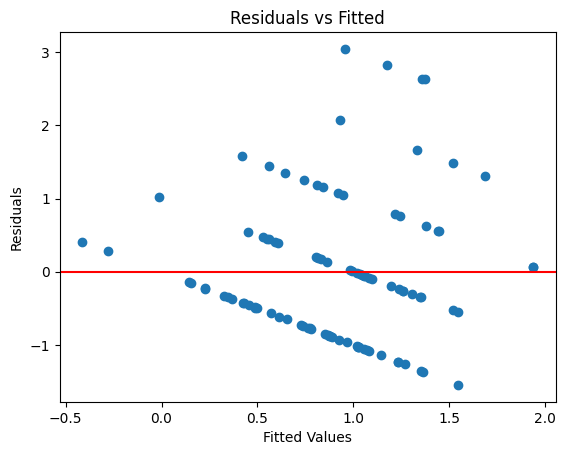

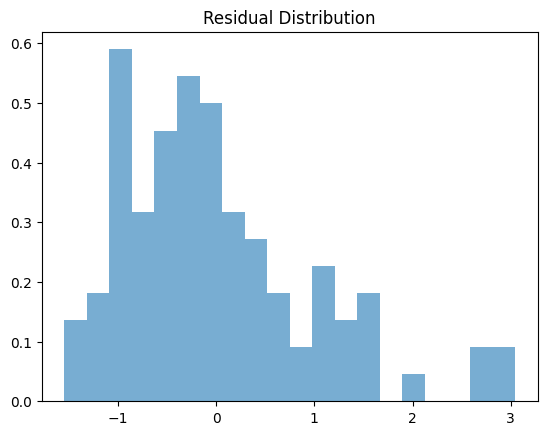

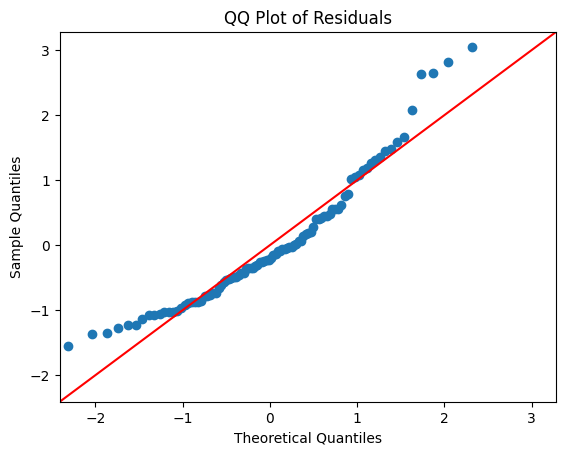

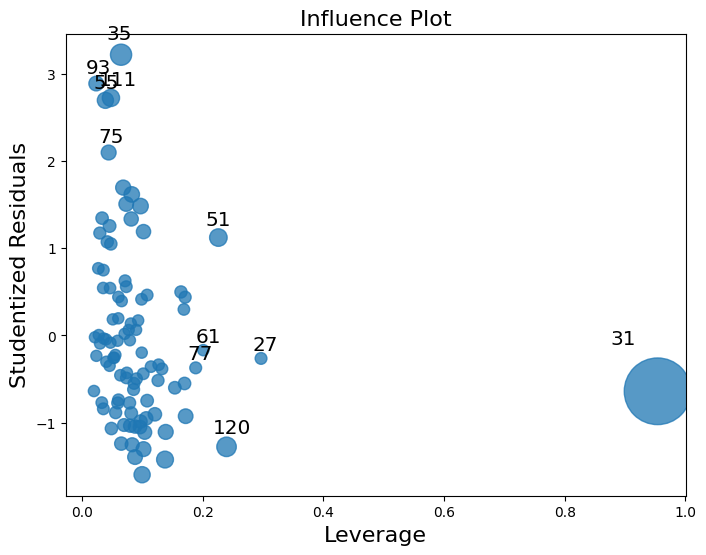

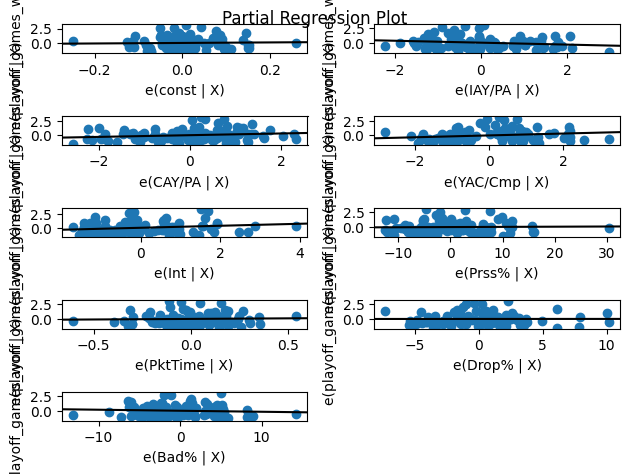

In [ ]:

predictors = [
    "IAY/PA",        # Intended Air Yards per Attempt
    "CAY/PA",        # Completed Air Yards per Attempt (or use CAY/Cmp instead)
    "YAC/Cmp",       # Yards after Catch per Completion
    "Int",           # Interceptions
    "Prss%",         # Pressure %
    "PktTime",       # Time to throw / pocket time
    "Drop%",         # Drop rate
    "Bad%",          # Bad throw rate
]

# Make sure columns exist
for col in predictors:
    if col not in df.columns:
        print(f"Missing column: {col}")

X = df[predictors]
y = df["playoff_games_won"]

# Drop rows with any missing values (common in football data)
combined = pd.concat([X, y], axis=1).dropna()
X = combined[predictors]
y = combined["playoff_games_won"]

# Add constant
X_const = sm.add_constant(X)

# 3. Fit linear model
model = sm.OLS(y, X_const).fit()
print(model.summary())

# 4. Check VIF for multicollinearity
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVariance Inflation Factors:")
print(vif_df)

# 5. Residual Diagnostics
# Residuals
residuals = model.resid
fitted = model.fittedvalues

# Plot: Residuals vs Fitted (Homoscedasticity + linearity)
plt.scatter(fitted, residuals)
plt.axhline(0, color='r')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Plot: Histogram + density of residuals (Normality)
plt.hist(residuals, bins=20, density=True, alpha=0.6)
plt.title("Residual Distribution")
plt.show()

# QQ Plot for normality
sm.qqplot(residuals, line='45')
plt.title("QQ Plot of Residuals")
plt.show()

# Influence Plot (high leverage points)
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.show()

fig = sm.graphics.plot_partregress_grid(model)


In [4]:
#lasso regression process
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = [0.005, 0.01, 0.02, 0.05, 0.1]

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000)
    lasso.fit(X_scaled, y)
    
    selected = [name for coef, name in zip(lasso.coef_, predictors) if coef != 0]
    print(f"alpha={a}: {selected}")

alpha=0.005: ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Prss%', 'PktTime', 'Drop%', 'Bad%']
alpha=0.01: ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Prss%', 'Drop%', 'Bad%']
alpha=0.02: ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.05: ['IAY/PA', 'YAC/Cmp', 'Int', 'Bad%']
alpha=0.1: ['IAY/PA', 'YAC/Cmp', 'Int', 'Bad%']


                            OLS Regression Results                            
Dep. Variable:      playoff_games_won   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     3.645
Date:                Wed, 26 Nov 2025   Prob (F-statistic):            0.00842
Time:                        13:02:46   Log-Likelihood:                -135.69
No. Observations:                  96   AIC:                             281.4
Df Residuals:                      91   BIC:                             294.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8012      0.602      1.332      0.1

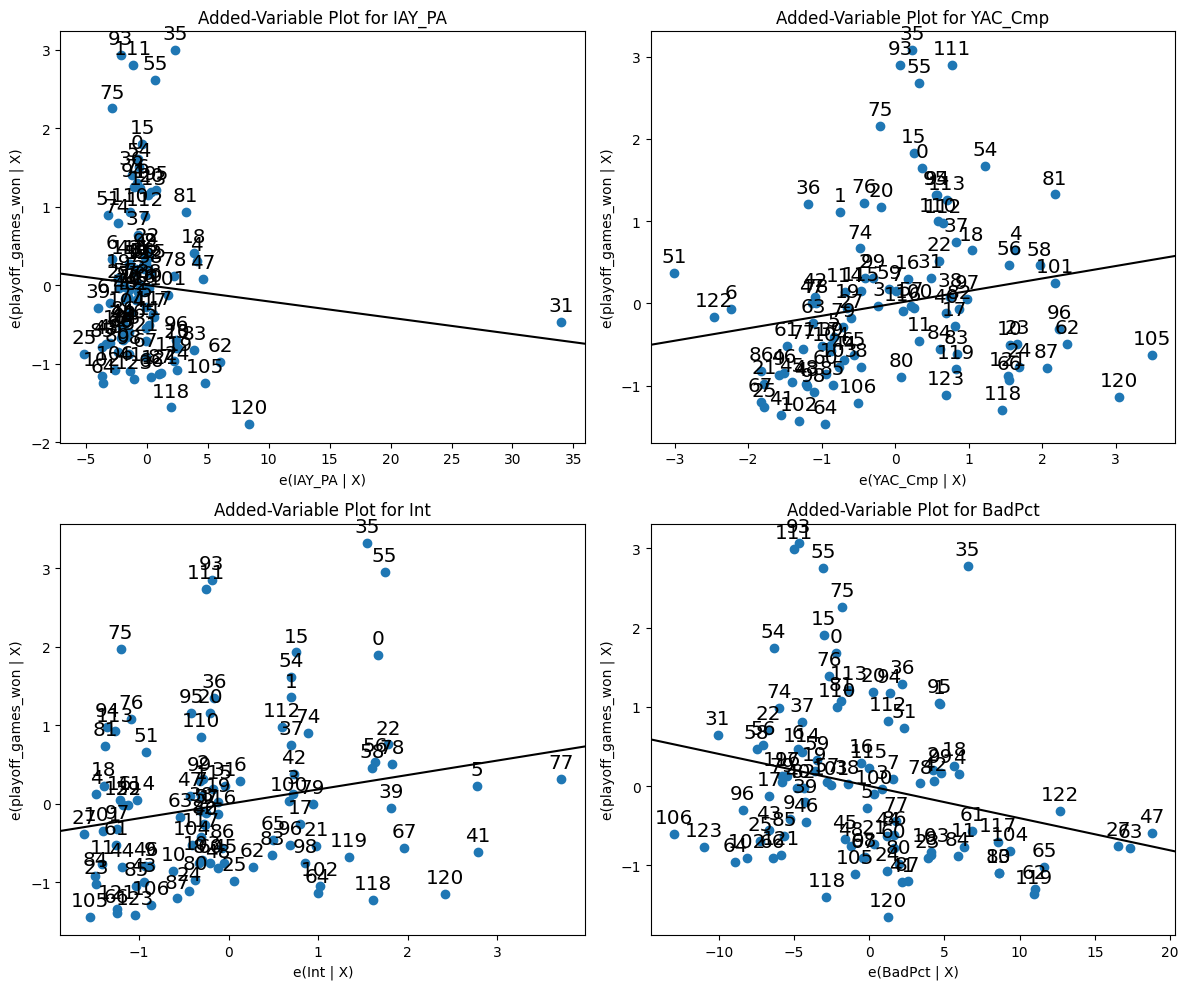

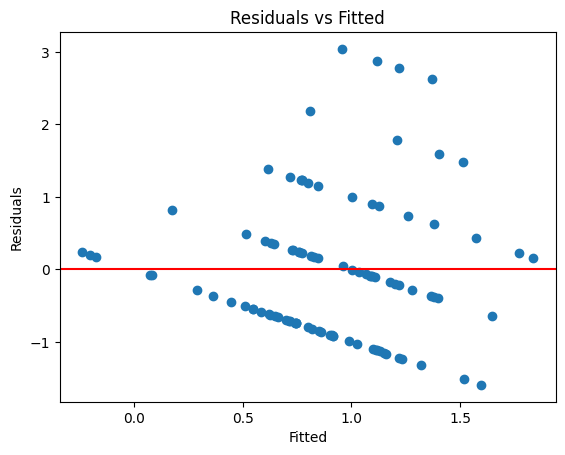

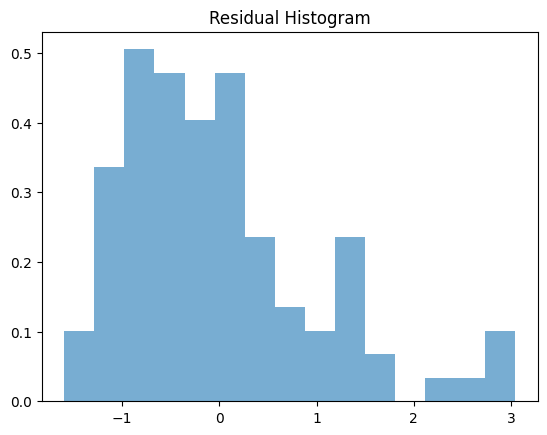

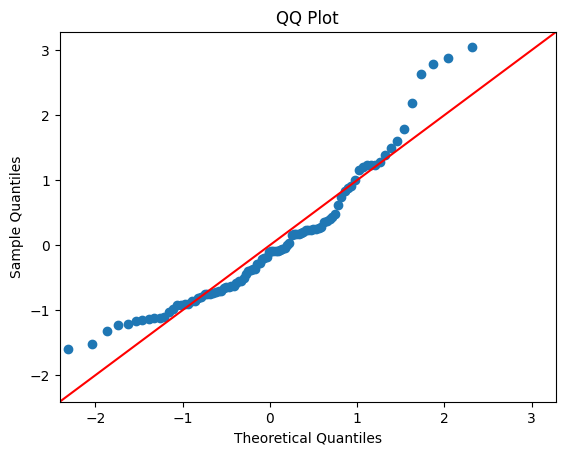


Shapiro-Wilk test: p = 0.0000

Breusch–Pagan Test:
LM Stat: 5.2664721418490394
LM p-value: 0.26103198267393013
F Stat: 1.3204847651727487
F p-value: 0.26833422657737627


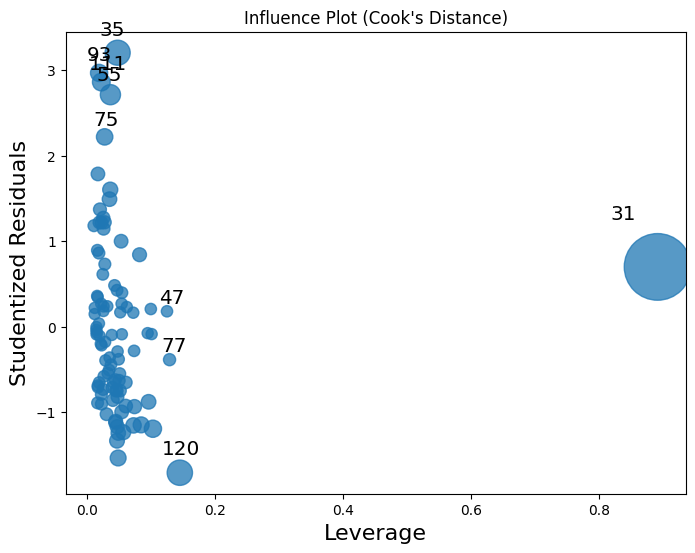

In [14]:
# ---- Select variables ----
predictors_original = ["IAY/PA", "YAC/Cmp", "Int", "Bad%"]
response = "playoff_games_won"

# Drop NA first
combined = df[predictors_original + [response]].dropna()

# ---- Rename messy columns FIRST ----
combined = combined.rename(columns={
    "IAY/PA": "IAY_PA",
    "YAC/Cmp": "YAC_Cmp",
    "Bad%": "BadPct"
})

# Updated predictor names
predictors = ["IAY_PA", "YAC_Cmp", "Int", "BadPct"]

# Now create X and y
X = combined[predictors]
y = combined[response]

# Add constant
X_const = sm.add_constant(X)

# -------------------------
# 2. Fit OLS model
# -------------------------
model = sm.OLS(y, X_const).fit()
print(model.summary())

# -------------------------
# 3. VIF (multicollinearity)
# -------------------------
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) 
                 for i in range(len(X.columns))]
print("\nVariance Inflation Factors:")
print(vif_df)

# -------------------------
# 4. Linearity checks (AV Plots)
# -------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, var in zip(axs.flatten(), predictors):
    others = [v for v in predictors if v != var]

    plot_partregress(
        endog=response,
        exog_i=var,
        exog_others=others,
        data=combined,
        ax=ax
    )

    ax.set_title(f"Added-Variable Plot for {var}")

plt.tight_layout()
plt.show()

# -------------------------
# 5. Residual diagnostics
# -------------------------
residuals = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, residuals)
plt.axhline(0, color='red')
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

plt.hist(residuals, bins=15, density=True, alpha=0.6)
plt.title("Residual Histogram")
plt.show()

sm.qqplot(residuals, line='45')
plt.title("QQ Plot")
plt.show()

# -------------------------
# 6. Normality test
# -------------------------
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\nShapiro-Wilk test: p = {shapiro_p:.4f}")

# -------------------------
# 7. Homoscedasticity test (Breusch–Pagan)
# -------------------------
bp_test = het_breuschpagan(residuals, X_const)
labels = ["LM Stat", "LM p-value", "F Stat", "F p-value"]
print("\nBreusch–Pagan Test:")
for name, val in zip(labels, bp_test):
    print(f"{name}: {val}")

# -------------------------
# 8. Influence diagnostics
# -------------------------
fig, ax = plt.subplots(figsize=(8, 6))
influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Cook's Distance)")
plt.show()


In [5]:
# poisson regression lasso selection
# -----
predictors = [
    "IAY/PA",
    "CAY/PA",
    "YAC/Cmp",
    "Int",
    "Prss%",
    "PktTime",
    "Drop%",
    "Bad%"
]

response = "playoff_games_won"

combined = df[predictors + [response]].dropna()
X = combined[predictors].values
y = combined[response].values

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept column
X_scaled = sm.add_constant(X_scaled)

# Variable names including intercept
var_names = ['Intercept'] + predictors

# -------------------------
# 2. Poisson Lasso variable selection
# -------------------------
alphas = [0.005, 0.01, 0.02, 0.05, 0.1]
print("Poisson Lasso Variable Selection:")

for a in alphas:
    poisson_lasso = sm.GLM(y, X_scaled, family=sm.families.Poisson()).fit_regularized(
        method='elastic_net',
        alpha=a,
        L1_wt=1.0,
        maxiter=50000
    )
    coefs = poisson_lasso.params
    selected = [name for name, coef in zip(var_names, coefs) if coef != 0 and name != 'Intercept']
    print(f"alpha={a}: selected variables = {selected}")
# -------------------------
# 3. Fit final Poisson GLM using selected variables
# -------------------------
alpha_final = 0.01
poisson_lasso_final = sm.GLM(y, X_scaled, family=sm.families.Poisson()).fit_regularized(
    method='elastic_net',
    alpha=alpha_final,
    L1_wt=1.0,
    maxiter=50000
)

coefs_final = poisson_lasso_final.params
selected_vars = [name for name, coef in zip(var_names, coefs_final) if coef != 0 and name != 'Intercept']
print(f"\nFinal selected variables (alpha={alpha_final}): {selected_vars}")


Poisson Lasso Variable Selection:
alpha=0.005: selected variables = ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.01: selected variables = ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.02: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.05: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']
alpha=0.1: selected variables = ['IAY/PA', 'YAC/Cmp', 'Int', 'Bad%']

Final selected variables (alpha=0.01): ['IAY/PA', 'CAY/PA', 'YAC/Cmp', 'Int', 'Drop%', 'Bad%']


                 Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.14
Date:                Wed, 26 Nov 2025   Deviance:                       110.04
Time:                        13:43:42   Pearson chi2:                     104.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1830
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2367      0.735      0.322      0.7

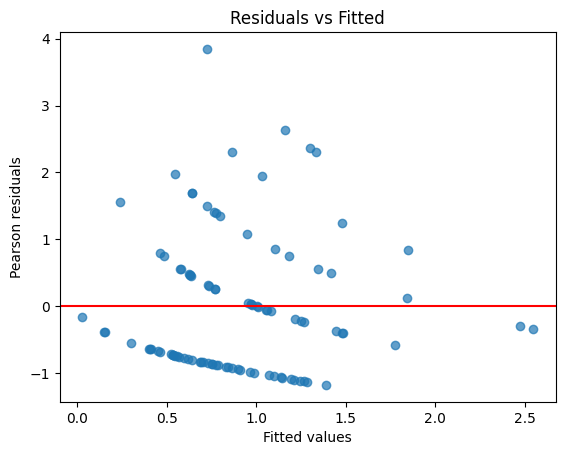

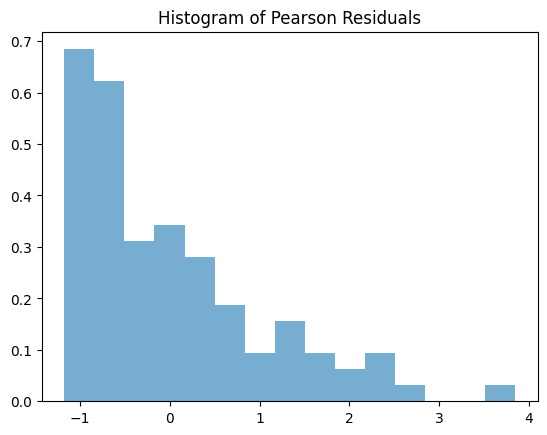

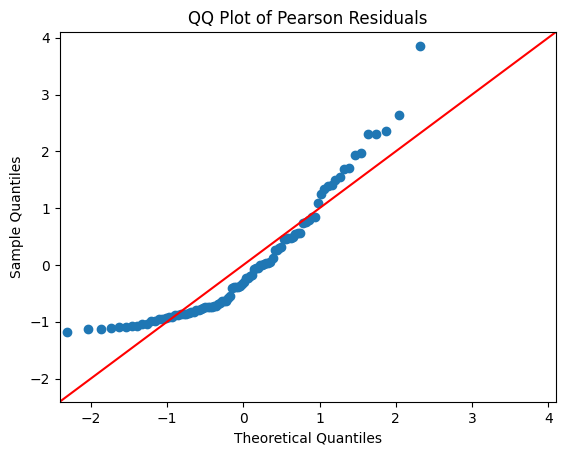


Overdispersion ratio: 1.15

Variance Inflation Factors for selected variables:
  Variable       VIF
0   IAY_PA  1.220788
1  YAC_Cmp  1.244601
2      Int  1.040519
3  DropPct  1.017297
4   BadPct  1.057405


In [12]:

# Rename columns to valid Python identifiers
combined = combined.rename(columns={
    "IAY/PA": "IAY_PA",
    "CAY/PA": "CAY_PA",
    "YAC/Cmp": "YAC_Cmp",
    "Prss%": "PrssPct",
    "Drop%": "DropPct",
    "Bad%": "BadPct"
})

# Update selected variables accordingly
selected_vars = ['IAY_PA', 'YAC_Cmp', 'Int', 'DropPct', 'BadPct']

# Now build formula
formula = response + " ~ " + " + ".join(selected_vars)

# Fit Poisson GLM
poisson_glm = smf.glm(formula=formula, data=combined, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())


# -------------------------
# 4. Residual diagnostics
# -------------------------
residuals = poisson_glm.resid_pearson
fitted = poisson_glm.fittedvalues

# Residuals vs Fitted
plt.scatter(fitted, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=15, density=True, alpha=0.6)
plt.title("Histogram of Pearson Residuals")
plt.show()

# QQ plot
sm.qqplot(residuals, line='45')
plt.title("QQ Plot of Pearson Residuals")
plt.show()

# -------------------------
# 5. Overdispersion check
# -------------------------
overdispersion = sum(residuals**2) / poisson_glm.df_resid
print(f"\nOverdispersion ratio: {overdispersion:.2f}")
if overdispersion > 1.5:
    print("Warning: potential overdispersion. Consider Negative Binomial regression.")

# -------------------------
# 6. Multicollinearity check (VIF)
# -------------------------
X_selected = combined[selected_vars]
X_const = sm.add_constant(X_selected)
vif_df = pd.DataFrame()
vif_df["Variable"] = selected_vars
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(selected_vars))]
print("\nVariance Inflation Factors for selected variables:")
print(vif_df)


In [19]:
# Rename df columns and store in combined
combined = df.rename(columns={
    "IAY/PA": "IAY_PA",
    "CAY/PA": "CAY_PA",
    "YAC/Cmp": "YAC_Cmp",
    "Prss%": "PrssPct",
    "Drop%": "DropPct",
    "Bad%": "BadPct"
})

combined_subset = combined[['playoff_games_won', 'Int', 'YAC_Cmp', 'IAY_PA', 'DropPct', 'BadPct']].dropna()

# 1. INT alone
formula1 = 'playoff_games_won ~ Int'
model1 = smf.glm(formula=formula1, data=combined_subset, family=sm.families.Poisson()).fit()
print("INT alone:\n", model1.summary())

# 2. INT + YAC_Cmp
formula2 = 'playoff_games_won ~ Int + YAC_Cmp'
model2 = smf.glm(formula=formula2, data=combined_subset, family=sm.families.Poisson()).fit()
print("\nINT + YAC_Cmp:\n", model2.summary())

# 3. Full selected variables
selected_vars = ['Int', 'YAC_Cmp', 'IAY_PA', 'DropPct', 'BadPct']
formula3 = 'playoff_games_won ~ ' + ' + '.join(selected_vars)
model3 = smf.glm(formula=formula3, data=combined_subset, family=sm.families.Poisson()).fit()
print("\nFull selected variables:\n", model3.summary())


INT alone:
                  Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       94
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -123.49
Date:                Wed, 26 Nov 2025   Deviance:                       124.74
Time:                        13:55:58   Pearson chi2:                     116.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04784
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3602      0.168     -2.

In [20]:
combined['IntPerAtt'] = combined['Int'] / combined['Att']

# Update selected variables: replace Int with IntPerAtt
selected_vars = ['IAY_PA', 'YAC_Cmp', 'IntPerAtt', 'DropPct', 'BadPct']

# Build formula
formula = response + " ~ " + " + ".join(selected_vars)

# Fit Poisson GLM
poisson_glm = smf.glm(formula=formula, data=combined, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      playoff_games_won   No. Observations:                   96
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.89
Date:                Wed, 26 Nov 2025   Deviance:                       111.55
Time:                        14:04:12   Pearson chi2:                     105.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1700
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3549      0.798      0.445      0.6

In [18]:
#CV

In [ ]:
#clustering analysis 